<a href="https://colab.research.google.com/github/ssunwalka01/v1/blob/master/Hackerearth_Internv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Happiness Source

In [0]:
# importing packages
import pandas as pd 
import numpy as np                     # For mathematical calculations 
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import nltk
import re
import codecs
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

Reading the Data

In [0]:
train=pd.read_csv('/content/hm_train.csv')
test=pd.read_csv('/content/hm_test.csv')
submission=pd.read_csv('/content/sample_submission.csv')

In [4]:
print(train.columns,test.columns,submission.columns)
print(train.head(),test.head(),submission.head())
print(train.shape,test.shape,submission.shape)

Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence',
       'predicted_category'],
      dtype='object') Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence'], dtype='object') Index(['hmid', 'predicted_category'], dtype='object')
    hmid reflection_period  ... num_sentence  predicted_category
0  27673               24h  ...            1           affection
1  27674               24h  ...            1           affection
2  27675               24h  ...            1            exercise
3  27676               24h  ...            2             bonding
4  27677               24h  ...            1           affection

[5 rows x 5 columns]     hmid  ... num_sentence
0  88305  ...            1
1  88306  ...            2
2  88307  ...            1
3  88308  ...            1
4  88309  ...            5

[5 rows x 4 columns]     hmid predicted_category
0  88305            bonding
1  88306        achievement
2  88307          affection
3  88308            bonding
4  88309 

- Let’s make a copy of train and test data so that even if we have to make any changes in these datasets we would not lose the original datasets.



In [0]:
train_copy=pd.read_csv('/content/hm_train.csv').copy()
test_copy=pd.read_csv('/content/hm_test.csv').copy()
submission_copy=pd.read_csv('/content/sample_submission.csv').copy()

# Univariate Analysis

In [6]:
print(train.dtypes,test.dtypes,submission.dtypes)

hmid                   int64
reflection_period     object
cleaned_hm            object
num_sentence           int64
predicted_category    object
dtype: object hmid                  int64
reflection_period    object
cleaned_hm           object
num_sentence          int64
dtype: object hmid                   int64
predicted_category    object
dtype: object


In [7]:
train['predicted_category'].value_counts(normalize=True)
# Read as percentage after multiplying by 100

affection           0.346148
achievement         0.336102
bonding             0.108768
enjoy_the_moment    0.107889
leisure             0.070324
nature              0.018683
exercise            0.012085
Name: predicted_category, dtype: float64

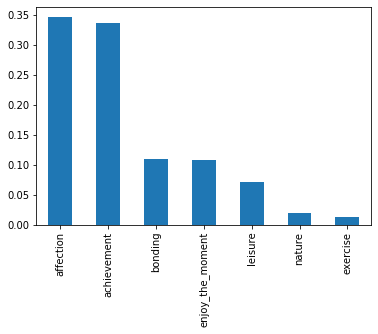

In [8]:
train['predicted_category'].value_counts(normalize=True).plot.bar()

- exercise featurescontributes approx 2%, nature contributes 3.5 %, leisure contributes 7.5%, enjoy_the_moment does 10%, bonding does 10%, achievement does 34%, and affection does34.5 % to the population sample.

On Looking at the datsets, we identified that there are 3 Data Types:

- Continuous : reflection_period, cleaned_hm ,num_sentence

- Categorical :Category

- Text : cleaned_hm

Let's go for Continuous Data Type Exploration. We know that we use BarGraphs for Categorical variable, Histogram or ScatterPlot for continuous variables.

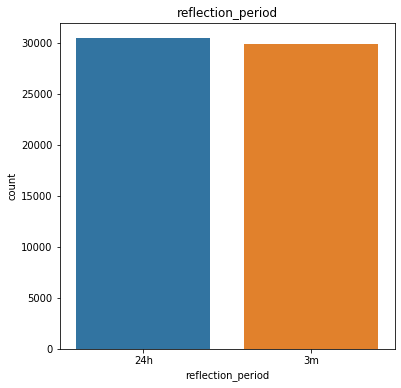

In [9]:
# reflection_period
plt.figure(figsize=(6, 6))
sns.countplot(train["reflection_period"])
plt.title('reflection_period')
plt.show()

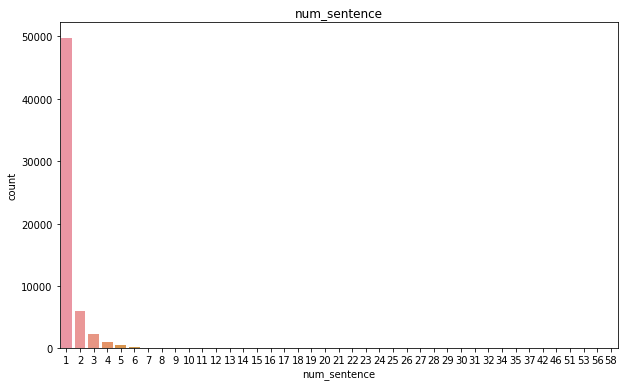

In [10]:
# num_sentence
plt.figure(figsize=(10, 6))
sns.countplot(train["num_sentence"])
plt.title('num_sentence')
plt.show()

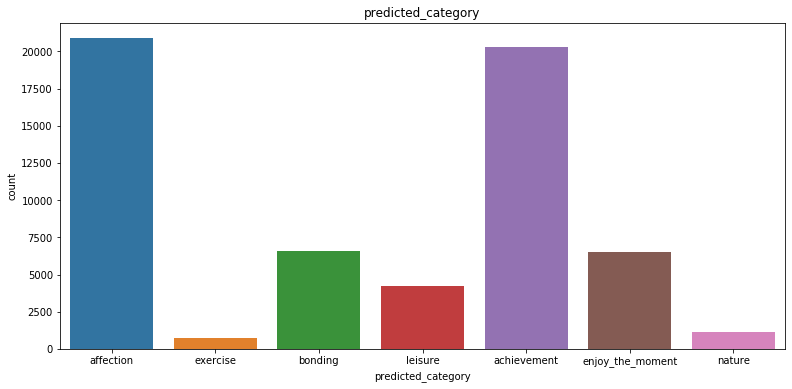

In [11]:
# predicted_category
plt.figure(figsize=(13, 6))
sns.countplot(train["predicted_category"])
plt.title('predicted_category')
plt.show()


<Figure size 2160x2160 with 0 Axes>

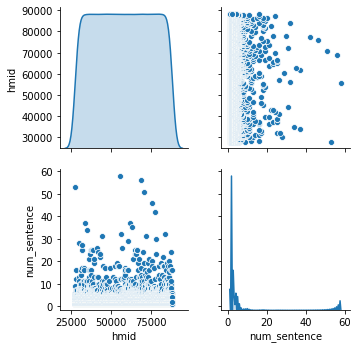

In [12]:
# Pairplot for cross visualisation of continuous variables
plt.figure(figsize=(30,30))
sns.pairplot(train, diag_kind='kde');

Data Preprocessing

- Checking Missing Values

In [0]:
def missing_value(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_df = pd.concat([total, percent], axis=1, keys = ['Total', 'Percent'])
    return missing_df

In [14]:
mis_train = missing_value(train)
mis_train

,Total,Percent
predicted_category,0,0.0
num_sentence,0,0.0
cleaned_hm,0,0.0
reflection_period,0,0.0
hmid,0,0.0


In [15]:
mis_test = missing_value(test)
mis_test

,Total,Percent
num_sentence,0,0.0
cleaned_hm,0,0.0
reflection_period,0,0.0
hmid,0,0.0


Text Preprocessing

In [0]:
#removing non-letter symbols and converting text in 'cleaned_hm' to lowercase 
train['cleaned_hm'] = train['cleaned_hm'].apply(lambda x: "".join(re.sub(r"[^A-Za-z\s]", '',str(x))))
test['cleaned_hm'] = test['cleaned_hm'].apply(lambda x: "".join(re.sub(r"[^A-Za-z\s]",'',str(x))))

In [17]:
train['cleaned_hm']

0        I went on a successful date with someone I fel...
1        I was happy when my son got  marks in his exam...
2              I went to the gym this morning and did yoga
3        We had a serious talk with some friends of our...
4        I went with grandchildren to butterfly display...
                               ...                        
60316    I got together with my best friend and baked c...
60317                  I went to a restaurant with friends
60318    The other day on Mechanical Turk I made over f...
60319    Finished the semester today and aced majority ...
60320    An event that made me happy in the past  month...
Name: cleaned_hm, Length: 60321, dtype: object

In [0]:
# lower casing the Text
train['cleaned_hm'] = train['cleaned_hm'].apply(lambda x: " ".join(x.lower() for x in x.split()))
test['cleaned_hm'] = test['cleaned_hm'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [19]:
train['cleaned_hm']

0        i went on a successful date with someone i fel...
1        i was happy when my son got marks in his exami...
2              i went to the gym this morning and did yoga
3        we had a serious talk with some friends of our...
4        i went with grandchildren to butterfly display...
                               ...                        
60316    i got together with my best friend and baked c...
60317                  i went to a restaurant with friends
60318    the other day on mechanical turk i made over f...
60319    finished the semester today and aced majority ...
60320    an event that made me happy in the past months...
Name: cleaned_hm, Length: 60321, dtype: object

In [0]:
#Removing punctuations
#adding characters list which needs to remove that is PUNCTUATION
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%",'/','<','>','br','�','^','XX','XXXX','xxxx','xx']
#removing extra characters
train['cleaned_hm'] = train['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in punc))
test['cleaned_hm'] = test['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in punc))

In [0]:
import nltk

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#removal of stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['cleaned_hm'] = train['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test['cleaned_hm'] = test['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [0]:
#common words removal
freq_train = pd.Series(' '.join(train['cleaned_hm']).split()).value_counts()[:10]
freq_test = pd.Series(' '.join(test['cleaned_hm']).split()).value_counts()[:10]
#freq_valid = pd.Series(' '.join(valid['Statement']).split()).value_counts()[:10]

freq_train = list(freq_train.index)
train['cleaned_hm'] = train['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_train))
freq_test = list(freq_test.index)
test['cleaned_hm'] = test['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_test))

In [0]:
#rare words removal
freq_train_rare = pd.Series(' '.join(train['cleaned_hm']).split()).value_counts()[-10:]
freq_train_rare = list(freq_train_rare.index)
train['cleaned_hm'] = train['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_train_rare))

freq_test_rare = pd.Series(' '.join(test['cleaned_hm']).split()).value_counts()[-10:]
freq_test_rare = list(freq_test_rare.index)
test['cleaned_hm'] = test['cleaned_hm'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_test_rare))

In [0]:
#STEMMING
st = PorterStemmer()
train['cleaned_hm']=train['cleaned_hm'].apply(lambda x: " ".join([st.stem(w) for w in x.split()]))
test['cleaned_hm']=test['cleaned_hm'].apply(lambda x: " ".join([st.stem(w) for w in x.split()]))

In [27]:
train.columns, test.columns

(Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence',
        'predicted_category'],
       dtype='object'),
 Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence'], dtype='object'))

onehotencoder = OneHotEncoder(categorical_features = [0,1])
    X = onehotencoder.fit_transform(X).toarray()
    sc_x = MinMaxScaler()
    X = sc_x.fit_transform(X)

In [28]:
#NOw We will convert the target variable into LabelEncoder
y_train = train.loc[:,['predicted_category']]
labelencoder1 = LabelEncoder()
labelencoder1.fit(y_train.values)
y_train=labelencoder1.transform(y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
try_train_ohe=y_train

In [0]:
# Removing .json extension
train['reflection_period'] = train['reflection_period'].str.rstrip('h | m')
test['reflection_period'] = test['reflection_period'].str.rstrip('h | m')

In [31]:
train['reflection_period']

0        24
1        24
2        24
3        24
4        24
         ..
60316     3
60317     3
60318     3
60319     3
60320     3
Name: reflection_period, Length: 60321, dtype: object

In [0]:
x = train.loc[:,["num_sentence","reflection_period","hmid"]]
x1 = test.loc[:,["num_sentence","reflection_period","hmid"]]

In [0]:
# Converting the Text into list
stat_train = train['cleaned_hm'].tolist()
stat_test = test['cleaned_hm'].tolist()

# Adding train and test data
lis_stat = stat_train + stat_test 

In [34]:
#Fitting TFIDF on summary
tfv_sum = TfidfVectorizer(max_features=5000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv_sum.fit(lis_stat)
print(tfv_sum.vocabulary_)
print(tfv_sum.idf_)
xtrain_tfv_sum =  tfv_sum.transform(stat_train).toarray()
xtest_tfv_sum = tfv_sum.transform(stat_test).toarray()
type(xtrain_tfv_sum)

{'success': 4299, 'date': 1097, 'someon': 4091, 'felt': 1623, 'connect': 924, 'son': 4096, 'mark': 2667, 'examin': 1498, 'gym': 1956, 'morn': 2841, 'yoga': 4978, 'seriou': 3902, 'talk': 4383, 'friend': 1750, 'late': 2455, 'understood': 4671, 'good': 1862, 'hang': 1980, 'grandchildren': 1887, 'butterfli': 590, 'display': 1251, 'medit': 2717, 'night': 2961, 'recip': 3568, 'bread': 510, 'came': 614, 'spectacular': 4138, 'gift': 1829, 'elder': 1390, 'brother': 543, 'realli': 3556, 'surpris': 4341, 'yesterday': 4975, 'mom': 2817, 'birthday': 423, 'enjoy': 1438, 'watch': 4832, 'cupcak': 1061, 'war': 4816, 'teen': 4419, 'children': 750, 'rd': 3545, 'place': 3277, 'duti': 1350, 'video': 4763, 'game': 1795, 'complet': 892, 'mile': 2768, 'run': 3764, 'break': 511, 'make': 2633, 'feel': 1618, 'strong': 4270, 'movi': 2862, 'fun': 1768, 'short': 3954, 'gold': 1855, 'trade': 4573, 'hear': 2024, 'song': 4097, 'nearli': 2923, 'imposs': 2189, 'angri': 139, 'look': 2578, 'thought': 4484, 'eas': 1363, 'd

numpy.ndarray

In [35]:
xtrain_tfv_sum.shape, xtest_tfv_sum.shape

((60321, 5000), (40213, 5000))

In [0]:
x_train = np.concatenate((x, xtrain_tfv_sum),axis = 1)
x_test = np.concatenate((x1, xtest_tfv_sum),axis = 1)

In [37]:
x_train.shape,x_test.shape

((60321, 5003), (40213, 5003))

In [0]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression(solver='lbfgs',multi_class='multinomial',random_state=0,C=10)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)

In [0]:
ans = labelencoder1.inverse_transform(y_pred)
type(ans)
ans = pd.DataFrame(ans)

In [0]:
id1=test.loc[:,['hmid']]
final_ans = [id1, ans]
final_ans = pd.concat(final_ans, axis=1)
final_ans.columns = ['hmid', 'predicted_category']
final_ans.to_csv('v1.csv',index=False)